# Build and train the model

In [2]:
import os
import math
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def train_model(train_file, model_file):
    # write your code here. You can add functions as well.
    # use torch library to save model parameters, hyperparameters, etc. to model_file
    print('Finished...')

if __name__ == "__main__":
    # make no changes here
    train_file = sys.argv[1]
    model_file = sys.argv[2]
    train_model(train_file, model_file)


Finished...


# Load and do the inference

# The network:
1. CNN character level word embedder
1. concatenate CNN embedding with word embedding
1. bi-directional LSTM block, looking at a sentence
1. fully conncected layer? (what does linear projection mean?)

In [3]:
!pip install fastprogress matplotlib
from fastprogress import progress_bar, master_bar
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

training_data = Path("../data/sents.train")

# Creating data input pipeline

In [4]:
import torch
import torch.utils.data


class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, to_lower=True, training=True):
        self.to_lower = to_lower
        self.training = training
        
        self.sentences = []
        self.vocab = []
        self.tags = []
        
        self.generate_dataset(path)
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentence_embs, tag_embs = self.transform_sentence(self.sentences[index])
        return sentence_embs, tag_embs
    
    def generate_dataset(self, path):
        with open(path, 'r') as input_file:
            self.sentences = input_file.read().split("\n")
            
            if len(self.vocab) == 0:
                self.create_vocabs(self.sentences)
                self.vocab_size = len(self.vocab)
                self.tag_size = len(self.tags)
            
            if self.sentences[-1] == "":
                self.sentences.pop()
    
    def create_vocabs(self, sentences):
        vocab_set = set()
        tag_set = set()

        for sentence in sentences:
            for word in sentence.split(" "):
                try:
                    word, tag = self.split_words_tag(word)
                    vocab_set.add(word.lower() if self.to_lower else word)
                    tag_set.add(tag)
                except RuntimeError:
                    print("Not a valid word/tag pair: " + word)

        self.vocab = list(vocab_set)
        self.tags = list(tag_set)
            
    def transform_sentence(self, sentence):
        numeric_sent = []
        tags = []

        for word_tag in sentence.split(" "):
            try:
                if self.training:
                    word, tag = self.split_words_tag(word_tag)
                    tag_id = self.tags.index(tag)
                else:
                    word = word_tag
                    
                word_id = self.vocab.index(word.lower() if self.to_lower else word)

            except RuntimeError:
                print("Not a valid word/tag pair: " + word_tag)
            except ValueError:
                print("Word not in the vocab: " + word_tag)
                # The id of an unknown word
                word_id = len(self.vocab) - 1

            numeric_sent.append(word_id)
            if self.training: tags.append(tag_id)

        return torch.tensor(numeric_sent), torch.tensor(tags) if self.training else []

    @staticmethod
    def split_words_tag(word):
        words_tag = word.split("/")
        
        if len(words_tag) < 2: 
            raise RuntimeError("Not a valid word/tag pair:" + word)
            
        tag = words_tag.pop()
        word = "/".join(words_tag)
        
        return word, tag
    
    def print_sentence(self, sentence):
        print(" ".join([self.vocab[word.item()] for word in sentence.view(-1)]))
                
    def decode_sentence(self, sentence):
        return [self.vocab[word.item()] for word in sentence.view(-1)]
    
    def decode_tags(self, tag_ids):
        return [self.tags[tag.item()] for tag in tag_ids.view(-1)]
    
    def __getstate__(self):
        d = dict(self.__dict__)
        del d['sentences']
        return d
    
    def __setstate(self, d):
        self.__dict__.update(d)
        self.__dict__.update({'sentences': []})

In [5]:
%%time
dataset = Dataset(training_data)

Not a valid word/tag pair: 
CPU times: user 1.44 s, sys: 2.15 ms, total: 1.44 s
Wall time: 1.45 s


## DataLoader implementation

In [6]:
from torch.utils.data import DataLoader

batch_size = 1
num_workers = 4


pos_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

# Initial simple model implementation 

## Proposed plan:
1. Begin with word-level LSTM (check for an example in forum)
2. Make it bi-directional
3. Add character-level CNN

Try a new notebook: https://polynote.org/docs/01-installation.html

In [7]:
class PipelineTestModel(nn.Module):
    def __init__(self, vocab_size, emb_dims, output_dims):
        super(PipelineTestModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dims = emb_dims
        self.output_dims = output_dims
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_dims)
        self.fc = nn.LSTM(self.emb_dims, self.output_dims)
        
    def forward(self, sentence):
        print(sentence.shape)
        emb = self.emb(sentence)
        print(emb.shape)
#         tags = F.softmax(self.fc(emb), dim=self.output_dims)
        tags = self.fc(emb.view(len(sentence), 1, -1))
        print(tags.shape)
        return tags    
    
    
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence[-1]), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence[-1]), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [8]:
embedding_dims = 128
hidden_dims = 64
vocab_size = dataset.vocab_size
tagset_size = dataset.tag_size

model = LSTMTagger(embedding_dims, hidden_dims, vocab_size, tagset_size)

In [9]:
pos_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

In [10]:
class TestEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden, out_dims):
        super(TestEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden = hidden
        self.out_dims = out_dims
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size)
        self.lstm = nn.LSTM(self.emb_size, self.hidden)
        self.fc = nn.Linear(self.hidden, self.out_dims)
        
    def forward(self, sentence):
        embeddings = self.emb(sentence)
        hidden, _ = self.lstm(embeddings)
#         return hidden.view(len(sentence[-1]), 1, -1)
        return self.fc(hidden.view(len(sentence[-1]), 1, -1)).view(1, len(sentence[-1]), -1)
    
test_model = TestEmbedding(dataset.vocab_size, 128, 10, dataset.tag_size)
loss_func = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


x, y = next(iter(pos_dataloader))

pred = test_model(x)
test_model.zero_grad()

print(pred.shape, " ", y.shape)

loss = loss_func(pred.view(-1, 45), y.view(-1))


# y1, (y2, y3) = test_model(x)
# print(y1.shape)
# print(y2.shape)
# print(y3.shape)

torch.Size([1, 49, 45])   torch.Size([1, 49])


## Pad the input so that it is possible to use mini-batches

- Padding | https://discuss.pytorch.org/t/understanding-pack-padded-sequence-and-pad-packed-sequence/4099
- Padding | https://discuss.pytorch.org/t/simple-working-example-how-to-use-packing-for-variable-length-sequence-inputs-for-rnn/2120

## The padding needs to take place in the DataLoader
- Most likely will need to use sampler & collate_fn


In [11]:
%%time

gpu = torch.device("cuda")

embedding_dims = 128
hidden_dims = 128
vocab_size = dataset.vocab_size + 1 # For unkown words
tagset_size = dataset.tag_size

model = LSTMTagger(embedding_dims, hidden_dims, vocab_size, tagset_size)
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1
fake_batch = 32

tag_size = dataset.tag_size
losses = []

i = 0

model.to(gpu)
model.zero_grad()

master = master_bar(range(epochs))
for epoch in master:
    for x, y in progress_bar(pos_dataloader, parent=master):
        if i % fake_batch == 0:
            optimizer.step() # does not work
            model.zero_grad()

        x, y = x.to(gpu), y.to(gpu)
        pred = model(x)
        loss = loss_func(pred.view(-1, tag_size), y.view(-1))
        loss.backward()
            
        if i % 100 == 0: losses.append(loss.item())
        i += 1
        
        

CPU times: user 1min 58s, sys: 13.7 s, total: 2min 11s
Wall time: 4min 24s


3.6346540451049805


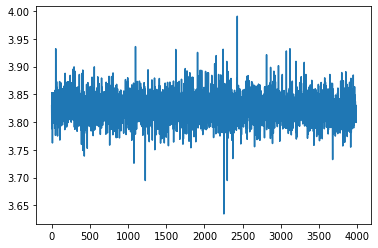

In [17]:
plt.plot(losses)
print(min(losses))

## Exporting trained model and built dictionary

In [18]:
def export_model(model, dataset, train_time):
    model_name = str(type(model)).split(".")[-1][:-2]
    model_save_name = model_name + "_" + str(train_time)
    
    torch.save(model, model_save_name + "_1.data")
    torch.save(dataset, model_save_name + "_2.data")

In [19]:
export_model(model, dataset, 5)


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTMTagger. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
